In [1]:
# If on Google Colab:

# Install pytorch and tqdm (if necessary)
#!pip install torch
#!pip install torchvision
#!pip install tqdm

# Mount your google drive as the data drive
# This will require google authorization
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import os
import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
from torch.nn.parameter import Parameter

In [3]:
class Args(object):
      def __init__(self, batch_size=64, test_batch_size=1000, epochs=10, lr=0.01, 
                   optimizer='adam', momentum=0.5, seed=1, log_interval=100, 
                   dataset='mnist', data_dir='./', cuda=True, features=784, classes=10, 
                   reg=False, margin=1, topk=5):
        
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.epochs = epochs
        self.lr = lr
        self.optimizer = optimizer
        self.momentum = momentum
        self.seed = seed
        self.log_interval = log_interval
        self.dataset = dataset
        self.data_dir = data_dir # Path to datasets
        self.cuda = cuda and torch.cuda.is_available()
        self.features = features # Number of input features
        self.classes = classes # Number of classes
        self.reg = reg # L2 regularization
        self.margin = margin # Margin in hinge loss
        self.topk = topk # Top-k accuracy

In [4]:
def prepare_mnist(args):
    DatasetClass = datasets.MNIST
    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
    dataset_dir = os.path.join(args.data_dir, args.dataset)
    
    train_dataset = DatasetClass(dataset_dir, train=True, download=True, 
                                 transform=transforms.Compose([
                                     transforms.ToTensor(), 
                                     transforms.Normalize((0.1307,), (0.3081,))]))
    
    test_dataset = DatasetClass(dataset_dir, train=False, 
                                transform=transforms.Compose([
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.1307,), (0.3081,))]))
    
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=args.batch_size, 
                                               shuffle=True, **kwargs)
    
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=args.test_batch_size, 
                                              shuffle=True, **kwargs)
    
    return train_loader, test_loader, train_dataset, test_dataset

In [5]:
def prepare_imagenet(args):
    dataset_dir = os.path.join(args.data_dir, args.dataset)
    train_dir = os.path.join(dataset_dir, 'train')
    val_dir = os.path.join(dataset_dir, 'val/images')
    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
    
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
    
    print('Preparing dataset ...')
    train_data = datasets.ImageFolder(train_dir, 
                                      transform=transforms.Compose([
                                          #transforms.RandomResizedCrop(56),
                                          #transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor()]))
    
    val_data = datasets.ImageFolder(val_dir, 
                                    transform=transforms.Compose([
                                        #transforms.RandomResizedCrop(56),
                                        transforms.ToTensor()]))
    
    print('Preparing data loaders ...')
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=args.batch_size, 
                                                    shuffle=True, **kwargs)
    
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=args.test_batch_size, 
                                                  shuffle=True, **kwargs)
    
    return train_data_loader, val_data_loader, train_data, val_data

Pre-calculated mean & std on imagenet:
```
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
```

For other datasets, we could just simply use 0.5:
```
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
```

In [6]:
def create_val_img_folder(args):
    '''
    This method is responsible for separating validation images into separate sub folders
    '''
    dataset_dir = os.path.join(args.data_dir, args.dataset)
    val_dir = os.path.join(dataset_dir, 'val')
    img_dir = os.path.join(val_dir, 'images')

    fp = open(os.path.join(val_dir, 'val_annotations.txt'), 'r')
    data = fp.readlines()
    val_img_dict = {}
    for line in data:
        words = line.split('\t')
        val_img_dict[words[0]] = words[1]
    fp.close()

    # Create folder if not present and move images into proper folders
    for img, folder in val_img_dict.items():
        newpath = (os.path.join(img_dir, folder))
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        if os.path.exists(os.path.join(img_dir, img)):
            os.rename(os.path.join(img_dir, img), os.path.join(newpath, img))

In [7]:
class SVM(nn.Module):
    def __init__(self, n_feature, n_class):
        super(SVM, self).__init__()
        self.fc = nn.Linear(n_feature, n_class)

    def forward(self, x):
        x = self.fc(x)
        return x

In [8]:
class MultiClassHingeLoss(nn.Module):
    def __init__(self, p=1, margin=20, size_average=True):
        super(MultiClassHingeLoss, self).__init__()
        self.p = p
        self.margin = margin
        self.size_average = size_average
        
    def forward(self, output, y):
        output_y = output[torch.arange(0, y.size()[0]).long(), y.data].view(-1, 1)
        loss = output - output_y + self.margin
        loss[torch.arange(0, y.size()[0]).long(), y.data] = 0
        loss[loss<0] = 0
        
        if(self.p != 1):
            loss = torch.pow(loss, self.p)
        
        loss = loss.mean() if self.size_average else loss.sum()
        return loss

In [9]:
def train(model, optimizer, train_loader, epoch, total_minibatch_count, train_losses, train_accs, args):
    model.train()
    correct, total_loss, total_acc = 0., 0., 0.
    progress_bar = tqdm.tqdm(train_loader, desc='Training')
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        # Stretch images to a 1D vector
        data = data.view(-1, args.features)
        
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        
        # Hinge loss
        hinge = MultiClassHingeLoss(margin=args.margin)
        loss = hinge(output, target)
        
        # L2 regularization
        if args.reg:
            l2_reg = None
            for W in model.parameters():
                if l2_reg is None:
                    l2_reg = W.norm(2)
                else:
                    l2_reg = l2_reg + W.norm(2)
            loss += 1/2 * l2_reg
        
        # Backpropagation  
        loss.backward()
        optimizer.step()
        
        # Compute top-k accuracy
        top_indices = torch.topk(output.data, args.topk)[1].t()
        match = top_indices.eq(target.view(1, -1).expand_as(top_indices))
        accuracy = match.view(-1).float().mean() * args.topk
        correct += match.view(-1).float().sum(0)

        if args.log_interval != 0 and total_minibatch_count % args.log_interval == 0:
            train_losses.append(loss.data[0])
            train_accs.append(accuracy.data[0])
            
        total_loss += loss.data
        total_acc += accuracy.data
            
        progress_bar.set_description(
            'Epoch: {} loss: {:.4f}, acc: {:.2f}'.format(
                epoch, total_loss / (batch_idx + 1), total_acc / (batch_idx + 1)))

        total_minibatch_count += 1

    return total_minibatch_count

In [10]:
def test(model, test_loader, epoch, val_losses, val_accs, args):
    model.eval()
    test_loss, correct = 0., 0.
    progress_bar = tqdm.tqdm(test_loader, desc='Validation')
    
    with torch.no_grad():
        for data, target in progress_bar:
            data = data.view(-1, args.features)
            
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            
            output = model(data)
            loss = MultiClassHingeLoss(margin=args.margin, size_average=False)
            test_loss += loss(output, target).data
            
            top_indices = torch.topk(output.data, args.topk)[1].t()
            match = top_indices.eq(target.view(1, -1).expand_as(top_indices))
            correct += match.view(-1).float().sum(0)
            
    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    val_losses.append(test_loss)
    val_accs.append(acc)
    
    progress_bar.clear()
    progress_bar.write(
        '\nEpoch: {} validation test results - Average val_loss: {:.4f}, val_acc: {}/{} ({:.2f}%)'.format(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    return acc

In [11]:
def run_experiment(args):
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
    
    if args.dataset == 'mnist':
        train_loader, test_loader, _, _ = prepare_mnist(args)
    else:
        # create_val_img_folder(args)
        train_loader, test_loader, _, _ = prepare_imagenet(args)
    
    model = SVM(args.features, args.classes)
    if args.cuda:
        model.cuda()

    if args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters())
    else:
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    total_minibatch_count = 0
    val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(1, args.epochs + 1):
        total_minibatch_count = train(model, optimizer, train_loader, epoch, 
                                      total_minibatch_count, train_losses, 
                                      train_accs, args)
        
        val_acc = test(model, test_loader, epoch, val_losses, val_accs, args)
        
    fig, axes = plt.subplots(1, 4, figsize=(13, 4))
    axes[0].plot(train_losses)
    axes[0].set_title('Loss')
    axes[1].plot(train_accs)
    axes[1].set_title('Acc')
    axes[1].set_ylim([0, 1])
    axes[2].plot(val_losses)
    axes[2].set_title('Val loss')
    axes[3].plot(val_accs)
    axes[3].set_title('Val Acc')
    axes[3].set_ylim([0, 1])
    plt.tight_layout()

Training:   0%|          | 0/938 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Epoch: 2 loss: 0.0422, acc: 0.92:   1%|▏         | 13/938 [00:00<00:14, 65.30it/s] 


Epoch: 1 validation test results - Average val_loss: 0.4161, val_acc: 9091.0/10000 (90.91%)


Epoch: 3 loss: 0.0417, acc: 0.91:   1%|▏         | 13/938 [00:00<00:13, 67.85it/s] 


Epoch: 2 validation test results - Average val_loss: 0.4259, val_acc: 9095.0/10000 (90.95%)


Epoch: 4 loss: 0.0363, acc: 0.92:   1%|▏         | 14/938 [00:00<00:12, 71.37it/s] 


Epoch: 3 validation test results - Average val_loss: 0.4296, val_acc: 9150.0/10000 (91.50%)


Epoch: 5 loss: 0.0377, acc: 0.92:   2%|▏         | 15/938 [00:00<00:12, 75.17it/s] 


Epoch: 4 validation test results - Average val_loss: 0.4130, val_acc: 9143.0/10000 (91.43%)


Epoch: 6 loss: 0.0362, acc: 0.92:   1%|▏         | 14/938 [00:00<00:13, 70.70it/s] 


Epoch: 5 validation test results - Average val_loss: 0.4310, val_acc: 9051.0/10000 (90.51%)


Epoch: 7 loss: 0.0377, acc: 0.91:   1%|▏         | 13/938 [00:00<00:13, 66.14it/s] 


Epoch: 6 validation test results - Average val_loss: 0.4118, val_acc: 9117.0/10000 (91.17%)


Epoch: 8 loss: 0.0387, acc: 0.91:   1%|▏         | 12/938 [00:00<00:15, 61.05it/s] 


Epoch: 7 validation test results - Average val_loss: 0.4184, val_acc: 9128.0/10000 (91.28%)


Epoch: 9 loss: 0.0323, acc: 0.93:   1%|▏         | 12/938 [00:00<00:14, 62.24it/s] 


Epoch: 8 validation test results - Average val_loss: 0.4265, val_acc: 9160.0/10000 (91.60%)


Epoch: 10 loss: 0.0332, acc: 0.92:   1%|▏         | 14/938 [00:00<00:12, 71.46it/s] 


Epoch: 9 validation test results - Average val_loss: 0.3997, val_acc: 9170.0/10000 (91.70%)


Validation: 100%|██████████| 10/10 [00:00<00:00, 13.46it/s]



Epoch: 10 validation test results - Average val_loss: 0.4194, val_acc: 9135.0/10000 (91.35%)


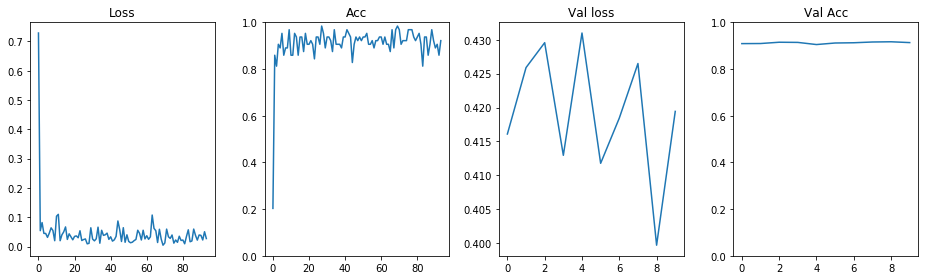

In [12]:
# On Mnist
run_experiment(Args(topk=1))

Preparing dataset ...


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Preparing data loaders ...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 2820.1965, val_acc: 1133.0/10000 (11.33%)


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 2625.0200, val_acc: 1304.0/10000 (13.04%)


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 2532.8022, val_acc: 1441.0/10000 (14.41%)


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 2474.9348, val_acc: 1454.0/10000 (14.54%)


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 2441.7964, val_acc: 1487.0/10000 (14.87%)


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 2410.0959, val_acc: 1577.0/10000 (15.77%)


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 2400.0823, val_acc: 1570.0/10000 (15.70%)


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 2383.5735, val_acc: 1621.0/10000 (16.21%)


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 2378.4661, val_acc: 1668.0/10000 (16.68%)


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]



Epoch: 10 validation test results - Average val_loss: 2350.1941, val_acc: 1663.0/10000 (16.63%)


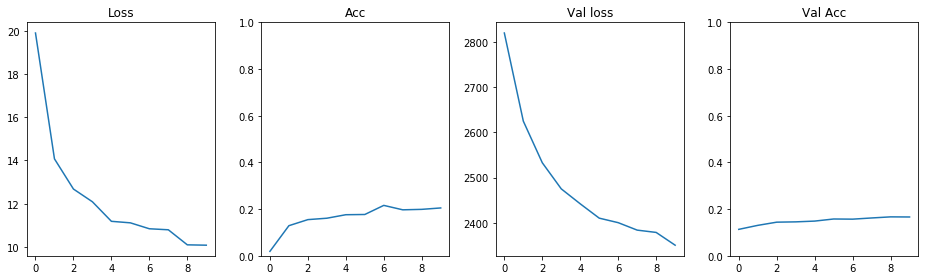

In [13]:
# On Tiny Imagenet
run_experiment(Args(dataset='tiny-imagenet-200', batch_size=1000, features=12288, classes=200, margin=20))